# Carga de librerías

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report

* os -> para poder navegar en los archivos locales y cargar las imágenes.
* cv2(OpenCV) -> se utiliza para el procesamiento de imágenes.
* numpy -> para las operaciones numéricas de las matrices que representan las imágenes.
* matplotlib -> para visualizar imágenes, resultados de los entrenamientos.
* skimage.feature: (local_binary_pattern y hog) se utilizan para convertir las imagenes en vectores con características numéricas.
* sklearn.model_selection:
    -   train_test_split: dividir el conjunto de datos en entrenamiento y prueba.
    -   StratifiefKFold: para validar pero mantenimiento la proporción en cada pliegue de la imegen.
    -   GridSearchCV: hace una validación cruzada para encontrar los mejores hiperparámetros.
* Algoritmos de entrenamiento y clasificación: SVM, Naive Bayes, Random Forest, VotingClassifier
* classification_report: generar un informe con la precisión, recall, F1-score por clase y asi comparar el rendimiento por clase.

# Preparación antes de carga de datos

In [2]:
# ruta de la imagenes
image_dir = "dataset/frutas"
# imagenes a buscar
classes = ["manzana", "naranja", "platano"]
# dimensiones de las imagenes
IMG_SIZE = (128, 128)

# A) Lectura de las imágenes de frutas (manzana, naranja y plátano), se muestran en color y posteriormente en escala de grises

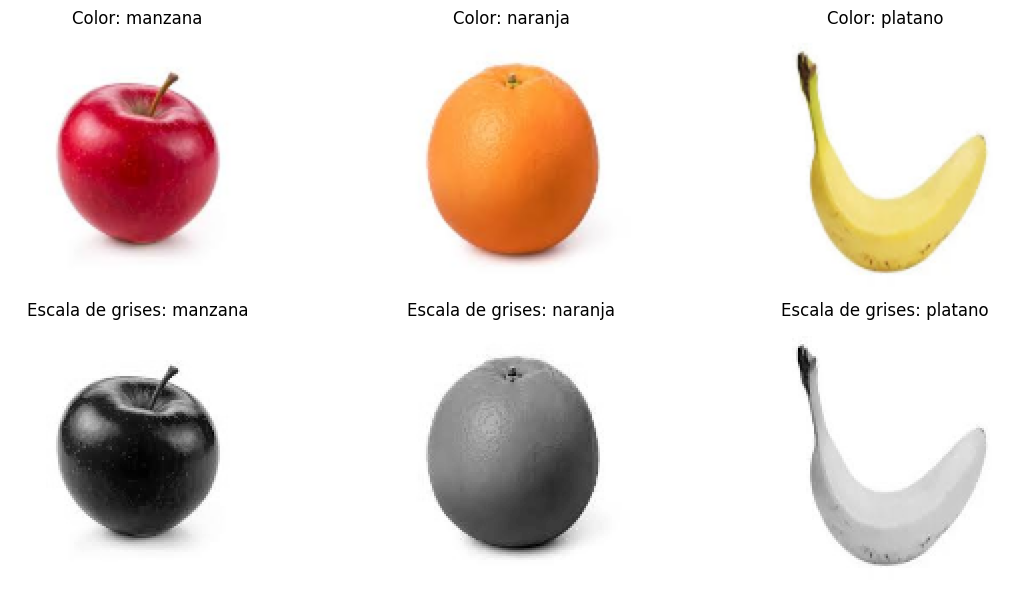

In [3]:
# Se hace la lectura de las imágenes, se aplica data augmentation y se visualización de imágenes
color_samples, gray_samples, label_samples = [], [], []
plt.figure(figsize=(12,6))
for i, cls in enumerate(classes):
    folder = os.path.join(image_dir, cls)
    fnames = os.listdir(folder)
    # Se visualiza la primera imagen en original y en escala de grises
    img0 = cv2.imread(os.path.join(folder, fnames[0]))
    img0 = cv2.resize(img0, IMG_SIZE)
    rgb0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    gray0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, len(classes), i+1)
    plt.imshow(rgb0); plt.title(f"Color: {cls}"); plt.axis('off')
    plt.subplot(2, len(classes), len(classes)+i+1)
    plt.imshow(gray0, cmap='gray'); plt.title(f"Escala de grises: {cls}"); plt.axis('off')
    # Data augmentation para cada imagen (para tener la imagen desde distintas formas y angulos)
    for fn in fnames:
        path = os.path.join(folder, fn)
        img = cv2.imread(path)
        if img is None: continue
        img = cv2.resize(img, IMG_SIZE)
        # original
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        color_samples.append(rgb); gray_samples.append(gray); label_samples.append(cls)
        # imagen volteada
        rgb_f = cv2.flip(rgb, 1)
        gray_f = cv2.flip(gray, 1)
        color_samples.append(rgb_f); gray_samples.append(gray_f); label_samples.append(cls)
        # rotada +15°
        M = cv2.getRotationMatrix2D((IMG_SIZE[0]//2, IMG_SIZE[1]//2), 15, 1.0)
        rgb_r = cv2.warpAffine(rgb, M, IMG_SIZE)
        gray_r = cv2.warpAffine(gray, M, IMG_SIZE)
        color_samples.append(rgb_r); gray_samples.append(gray_r); label_samples.append(cls)
        # rotada -15°
        M2 = cv2.getRotationMatrix2D((IMG_SIZE[0]//2, IMG_SIZE[1]//2), -15, 1.0)
        rgb_r2 = cv2.warpAffine(rgb, M2, IMG_SIZE)
        gray_r2 = cv2.warpAffine(gray, M2, IMG_SIZE)
        color_samples.append(rgb_r2); gray_samples.append(gray_r2); label_samples.append(cls)
plt.tight_layout(); plt.show()


# B) Extracción de características básicas y avanzadas

In [4]:
features = []
for gray, rgb in zip(gray_samples, color_samples):
    feats = []
    # media y desviación estándar
    feats.append(np.mean(gray))
    feats.append(np.std(gray))
    # histograma de gris (16 bins)
    hist_g = cv2.calcHist([gray], [0], None, [16], [0,256]).flatten()
    feats.extend((hist_g/hist_g.sum()).tolist())
    # histograma color (8 bins canal)
    for c in range(3):
        hist_c = cv2.calcHist([rgb], [c], None, [8], [0,256]).flatten()
        feats.extend((hist_c/hist_c.sum()).tolist())
    # LBP
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0,9))
    feats.extend((hist_lbp/hist_lbp.sum()).tolist())
    # HOG
    hog_feats = hog(gray, orientations=9, pixels_per_cell=(8,8),
                    cells_per_block=(2,2), block_norm='L2-Hys', feature_vector=True)
    feats.extend(hog_feats.tolist())
    features.append(feats)
# Matrices X,y
dim = len(features[0])
X = np.array(features)
y = np.array(label_samples)
print(f"Total muestras: {X.shape[0]}, características: {X.shape[1]}")

# Escalado general
dim_scaler = StandardScaler().fit(X)
X_scaled = dim_scaler.transform(X)


Total muestras: 120, características: 8151


- El resultado nos muestra que hemos pasado de 30 muestras a 120 muestras, teniendo en cuenta las distintas posiciones de la imagen.
- Tenemos 8151 características (viene dada de las concatenación de los 2 valores estadísticos, los bins de los histogramas de escala de grises, RGB y LBP y el restante viene de los vectores HOG que aporta la información de las dimensiones.


# División de los datos para el entreno

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# C)Entrenamiento con un clasificador SVM y evalúación con score() y classification_report().

In [6]:
param_svm = {'kernel':['linear','rbf','poly'], 'C':[0.01,0.1,1,10],
             'gamma':['scale','auto'], 'degree':[2,3], 'class_weight':[None,'balanced']}
grid_svm = GridSearchCV(SVC(random_state=42), param_svm,
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
print(f"Mejor SVM: {grid_svm.best_params_}, CV acc: {grid_svm.best_score_:.2f}")
y_pred_svm = best_svm.predict(X_test)
print(f"SVM score(): {best_svm.score(X_test,y_test):.2f}")
print(classification_report(y_test, y_pred_svm, target_names=classes))


Mejor SVM: {'C': 0.01, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}, CV acc: 0.70
SVM score(): 0.75
              precision    recall  f1-score   support

     manzana       0.67      0.50      0.57         8
     naranja       0.67      0.75      0.71         8
     platano       0.89      1.00      0.94         8

    accuracy                           0.75        24
   macro avg       0.74      0.75      0.74        24
weighted avg       0.74      0.75      0.74        24



* C = 0.01 : este margen se utiliza para generalizar mejor los datos a cambio de tener un pequeños errores más. 
* Kernel lineal: asume que no hace falta transformar el espacio para la separación de clases.
* CV acc = 0.70: nos indica que la validación cruzda media sea del 70%.
* SVM score = 0.75 : la precisión global sobre el conjunto de pruebas es del 75%. Esto significa que ese porcentaje de imagene son clasificadas correctamente. 


- El modelo distingue bien los plátanos, pero confunde las manzanas con las otras frutas.

# D) Entrenamiento y evaluacion con el clasificador Naive Bayes, usando métricas y funciones biblioteca Scikit-Learn.

In [7]:
param_nb = {'var_smoothing':[1e-9,1e-8,1e-7,1e-6]}
grid_nb = GridSearchCV(GaussianNB(), param_nb,
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train, y_train)
best_nb = grid_nb.best_estimator_
print(f"Mejor NB: {grid_nb.best_params_}, CV acc: {grid_nb.best_score_:.2f}")
y_pred_nb = best_nb.predict(X_test)
print(f"NB score(): {best_nb.score(X_test,y_test):.2f}")
print(classification_report(y_test, y_pred_nb, target_names=classes))


Mejor NB: {'var_smoothing': 1e-09}, CV acc: 0.68
NB score(): 0.58
              precision    recall  f1-score   support

     manzana       0.40      0.50      0.44         8
     naranja       0.40      0.25      0.31         8
     platano       0.89      1.00      0.94         8

    accuracy                           0.58        24
   macro avg       0.56      0.58      0.56        24
weighted avg       0.56      0.58      0.56        24



- var_smoothing : contorola el sesgo y se evita la división entre cero.
- CV acc = 0.68 : nos indica que la validación cruzada media sea del 68%.
- NB score = 0.58 : precision global sobre el conjunto de pruebas es del 58% para clasificar las imagenes correctamente.


* Conclusión comparada con SVM: 
    - Naive Bayes pierde capacidad para diferenciar manzanas y naranjas.
    - Platanos los separan igual de bien.




In [8]:
# Prueba con VotingClassifier
clf_voting = VotingClassifier([
    ('svm', best_svm),
    ('nb', best_nb),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
], voting='hard')
clf_voting.fit(X_train, y_train)
y_pred_vote = clf_voting.predict(X_test)
print(f"Ensemble score(): {clf_voting.score(X_test,y_test):.2f}")
print(classification_report(y_test, y_pred_vote, target_names=classes))

Ensemble score(): 0.62
              precision    recall  f1-score   support

     manzana       0.43      0.38      0.40         8
     naranja       0.50      0.50      0.50         8
     platano       0.89      1.00      0.94         8

    accuracy                           0.62        24
   macro avg       0.61      0.62      0.61        24
weighted avg       0.61      0.62      0.61        24



* Ensemble score = 0.62 : el porcentaje global de aciertos es del 62% en la clasificación.


Conclusiones: El ensemble no supera al SVM puro, aunque corrige algo el desastre de NB en naranja. 